Link do interaktywnej wesji colabowej:
https://colab.research.google.com/drive/1ZCKT6as6Nk3NA_RefgdPn3F1YboEvqFZ?usp=sharing

In [1]:
import pandas as pd
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
wybory_df = pd.read_csv('wybory_reddit_final.csv',
                        lineterminator='\n')

In [3]:
wybory_df = wybory_df[wybory_df['author'] != "anon"]

In [4]:
wybory_df.head(2)

body     created       author  \
0  W krótce wybory a ja sobie zdałam sprawę że ni...  2023-08-31  krowajestes   
1  Mam takie pytanie Będzie to mój pierwszy udzia...  2023-10-14      DDDOMIK   

   num_comments  score  downs   topic       id  sentiment_score  sentiment  \
0           101     48      0  wybory  1668zix        -0.576105  negatywny   
1            34      0      0  wybory  177jq7t        -0.358143  negatywny   

   topics_bert                                     Processed text  LDA_topic  \
0            0  ['krótka', 'wybory', 'siebie', 'zdać być', 'sp...          0   
1            0  ['mieć', 'pytanie', 'pierwszy', 'udział', 'wyb...          1   

   topic_name  
0      Partie  
1  Czyny PiSu

#1. Budowa sieci społecznych

Dla wybranego z hashtagów w posiadanym zbiorze danych, używając dowolnego, wybranego narzędzia do budowy sieci (np. networkX, igraph, graph-tool - benchmark tutaj).

a) (2 pkt) zbuduj sieć łączącą użytkowników:

jako węzły sieci przyjmij poszczególnych użytkowników,
niech krawędzie symbolizują wybrane relacje między użytkownikami.
W zależności od posiadanych danych może być to np. relacja wspólnej dyskusji w obrębie jednej konwersacji, relacja wspominania się w swoich wzmiankach, relacja polubienia swoich wpisów itp. W przypadku zbioru o niskiej jakości, możesz użyć kombinacji różnych relacji

b) (1 pkt) zaraportuj podstawową charakterystykę uzyskanej sieci:

ilość węzłów,
ilość krawędzi,
histogram stopnia węzłów.

c) (2 pkt) zwizualizuj tak otrzymaną sieć w formie graficznej. Możesz użyć podzbioru użytkowników w celu zapewnienia czytelności prezentacji (np. najpopularniejszych).

In [5]:
#Wybieram #PiS
pis_df = wybory_df[wybory_df['topic'] == 'pis']

In [6]:
n_users = pis_df['author'].nunique()
print(f'Num of users inside PiS topic: {n_users}')

Num of users inside PiS topic: 752


In [7]:
G = nx.Graph()

for author in pis_df['author'].unique():
  G.add_node(author)

for post_id in pis_df['id']:
  #Znajdowanie powiązanych osób poprzez wspólną wktywność pod 1 postem
  authors_related = pis_df[pis_df['id'] == post_id]['author'].tolist()
  if len(authors_related) > 1:
    for i in range(len(authors_related)):
      for j in range(i + 1, len(authors_related)):
        if (authors_related[i] != authors_related[j]):
          G.add_edge(authors_related[i], authors_related[j])

In [8]:
#ilość węzłów, ilość krawędzi, histogram stopnia węzłów.
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Ilość węzłów: {num_nodes}\nIlość krawędzi: {num_edges}')

Ilość węzłów: 752
Ilość krawędzi: 3589


In [9]:
nodes_degree = list(G.degree(G.nodes))
G_df = pd.DataFrame(nodes_degree,columns=['author', 'node_degree'])

In [12]:
G_df['node_degree'].nunique()

45

In [17]:
fig = px.histogram(G_df, x='node_degree',
                   width=800, height=500,
                   title='Histogram stopni węzłów', nbins=115)
fig.show()

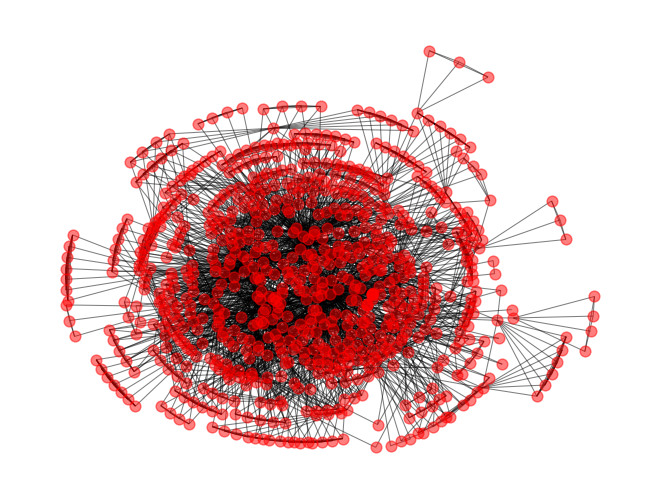

In [18]:
nx.draw_kamada_kawai(G, node_size=60, alpha=0.5, width=0.75, node_color="red")

In [ ]:
!pip install pyvis
!pip install jinja2

In [ ]:
from pyvis.network import Network
from IPython.core.display import display, HTML

In [ ]:
#Grupowanie po autorach i posortowanie
wybory_users_count = pis_df.groupby('author').size().reset_index(name='count')
wybory_users_count = wybory_users_count.sort_values(by='count', ascending=False)
sorted_users = list(wybory_users_count['author'])

top70users_df = pis_df[pis_df['author'].isin(sorted_users[:71])]

In [ ]:
users_to_keep = list(top70users_df['author'])

In [ ]:
filtered_G = G.subgraph(users_to_keep)

In [ ]:
net = Network(notebook=True, cdn_resources='in_line')


for node in filtered_G.nodes:
    net.add_node(node)

for edge in filtered_G.edges:
    net.add_edge(edge[0], edge[1])

net.show_buttons(filter_=['physics'])


net.show('graph.html')
display(HTML('graph.html'))

graph.html


In [ ]:
net

<class 'pyvis.network.Network'> |N|=70 |E|=282

#2 Detekcja społeczności

- Odkryj społeczności występujące w stworzonych sieciach, np. implementując samodzielnie lub używając jednej z zaimplementowanych w użytej bibliotece metod (https://memgraph.com/blog/community_detection-algorithms_with_python_networkx).

- Zaraportuj podstawowe charakterystyki stworzonych społeczności (ilość węzłów i krawędzi)

In [19]:
import community

# communities_generator = nx.community.girvan_newman(G)
communities = list(nx.community.louvain_communities(G, seed=123))

In [20]:
communities = [c for c in communities if len(c) > 2]

In [21]:
print(f'Ilość społeczności: {len(communities)}')

Ilość społeczności: 22


In [22]:
# Rozmiary społeczności
for i, community in enumerate(communities):
    subgraph = G.subgraph(community)
    #obliczenie centralnych węzłów społeczności
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    central_node = max(betweenness_centrality, key=betweenness_centrality.get)
    print(f"Społeczność {i + 1}: {subgraph}")
    print(f"Najbardziej centralny węzeł: {central_node}\n")

Społeczność 1: Graph with 36 nodes and 140 edges
Najbardziej centralny węzeł: Megamind_43

Społeczność 2: Graph with 9 nodes and 36 edges
Najbardziej centralny węzeł: genetivus_absolutus

Społeczność 3: Graph with 39 nodes and 149 edges
Najbardziej centralny węzeł: VladeMercer

Społeczność 4: Graph with 32 nodes and 123 edges
Najbardziej centralny węzeł: Fantastic_difficult

Społeczność 5: Graph with 43 nodes and 160 edges
Najbardziej centralny węzeł: idk2612

Społeczność 6: Graph with 30 nodes and 99 edges
Najbardziej centralny węzeł: Not_a_Krasnal

Społeczność 7: Graph with 28 nodes and 94 edges
Najbardziej centralny węzeł: MakaronAlma

Społeczność 8: Graph with 52 nodes and 192 edges
Najbardziej centralny węzeł: nightblackdragon

Społeczność 9: Graph with 27 nodes and 74 edges
Najbardziej centralny węzeł: Jan_Pawel2

Społeczność 10: Graph with 37 nodes and 135 edges
Najbardziej centralny węzeł: Bielin_Clash

Społeczność 11: Graph with 28 nodes and 98 edges
Najbardziej centralny węze

In [23]:
num_nodes = []
num_edges = []

for community in communities:
    subgraph = G.subgraph(community)
    num_nodes.append(subgraph.number_of_nodes())
    num_edges.append(subgraph.number_of_edges())

fig = px.scatter(x=num_nodes, y=num_edges, width=800, height=400,
                 labels={'x': 'Number of Nodes', 'y': 'Number of Edges'},
                 title='Communities stats')
fig.update_traces(marker=dict(size=8))

fig.show()

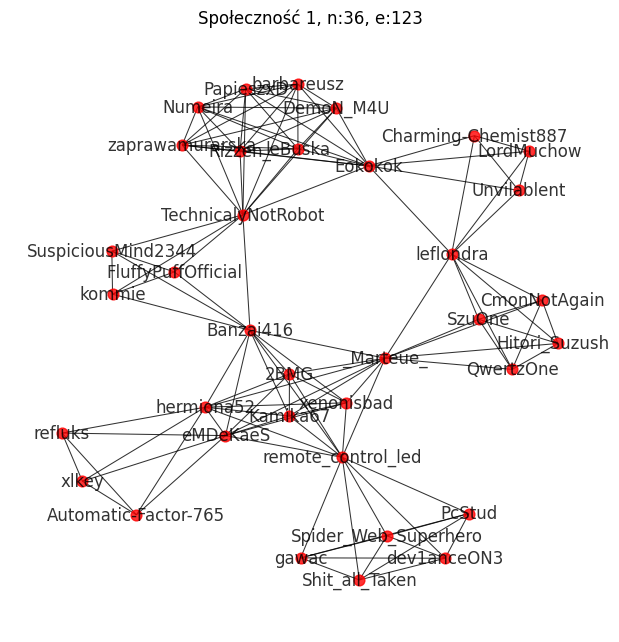

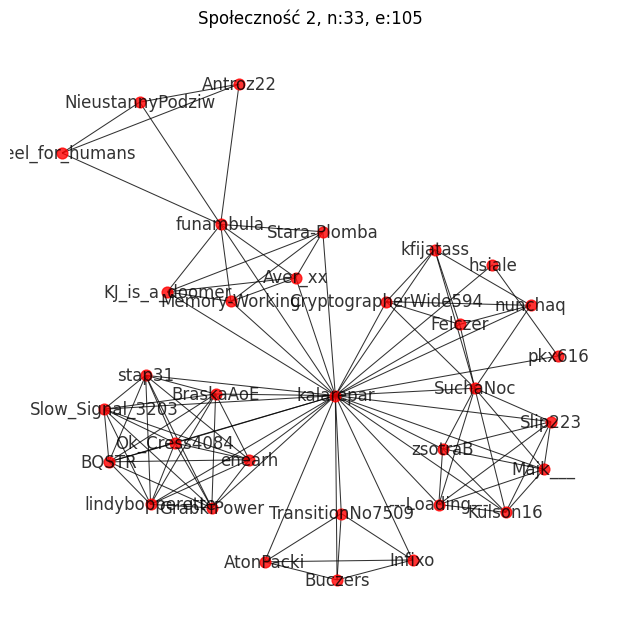

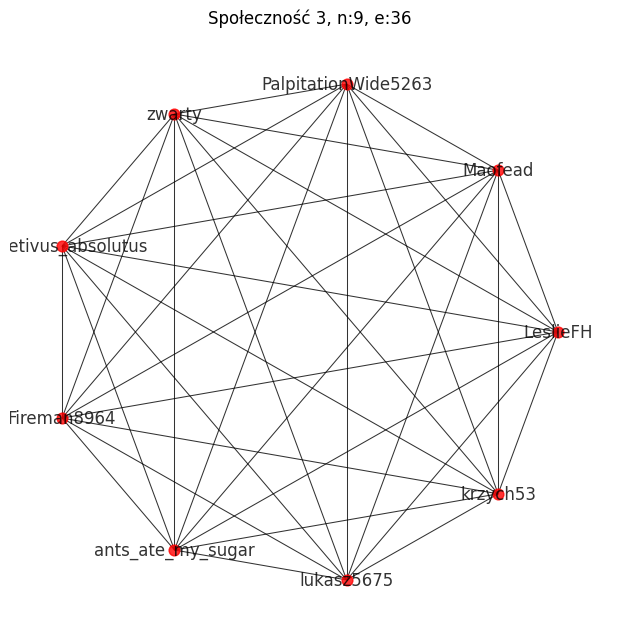

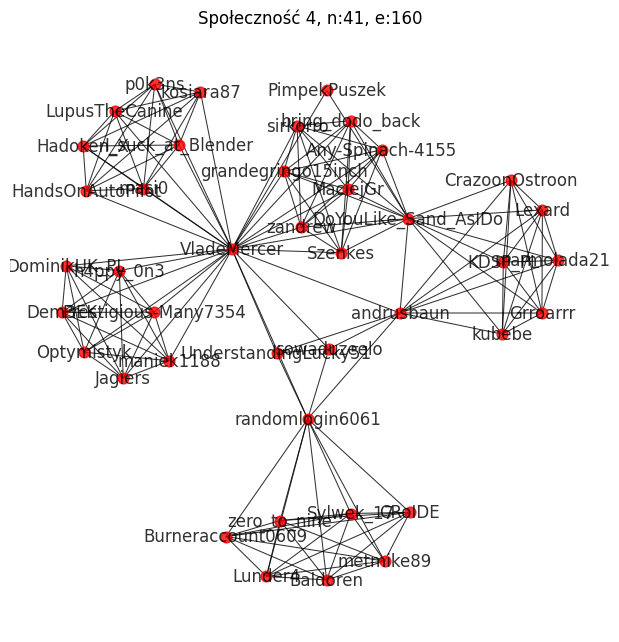

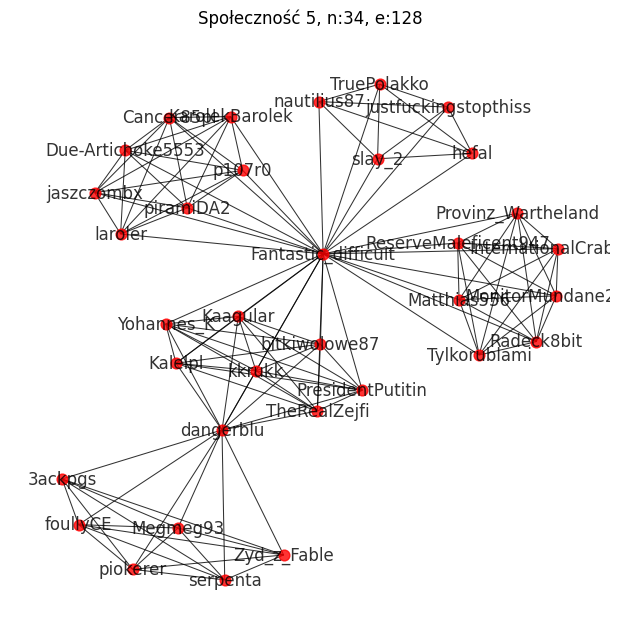

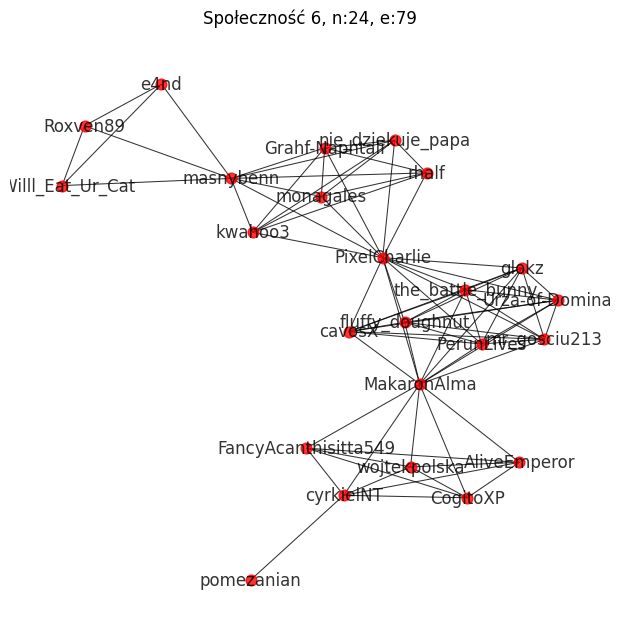

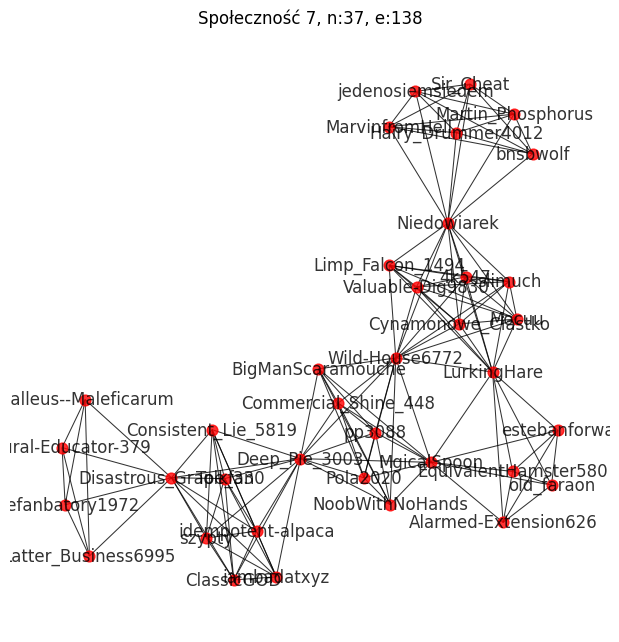

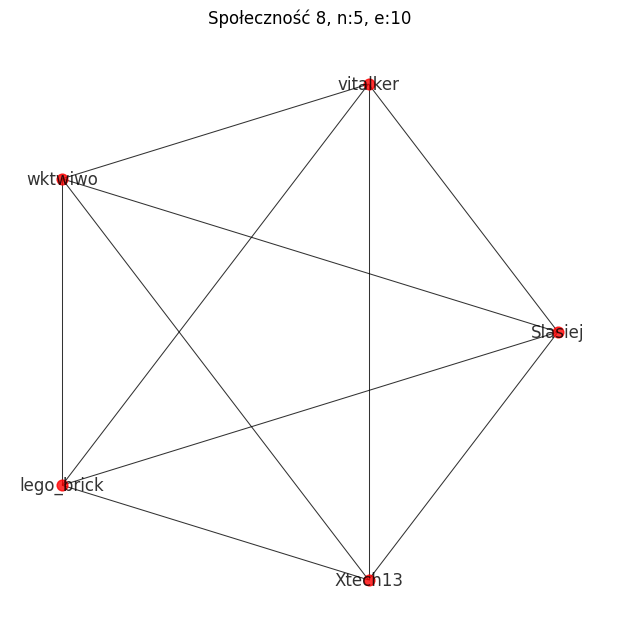

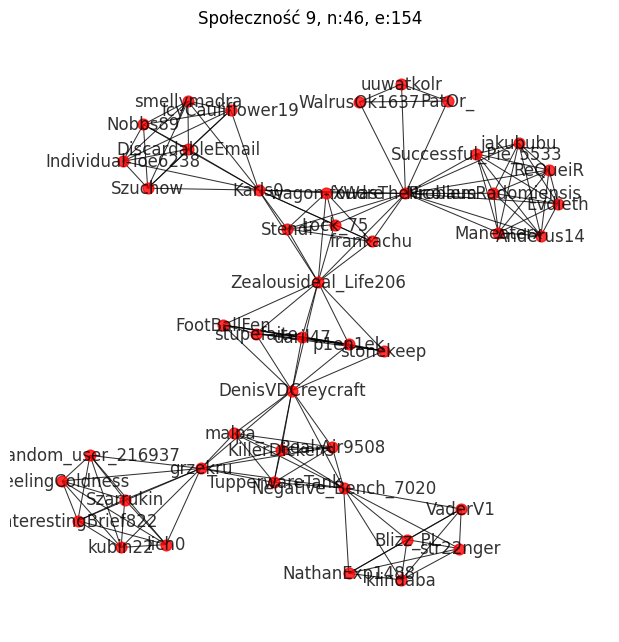

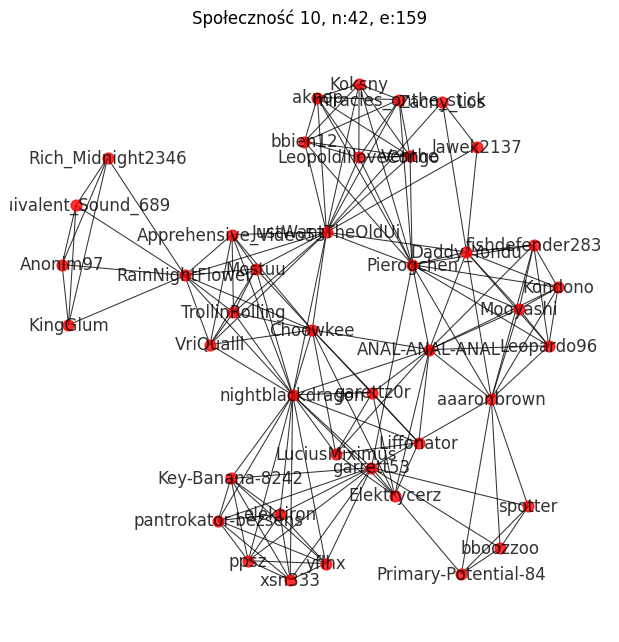

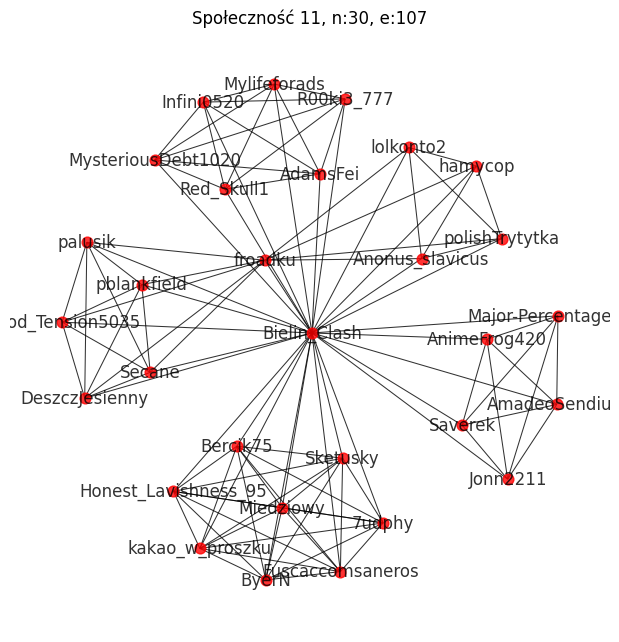

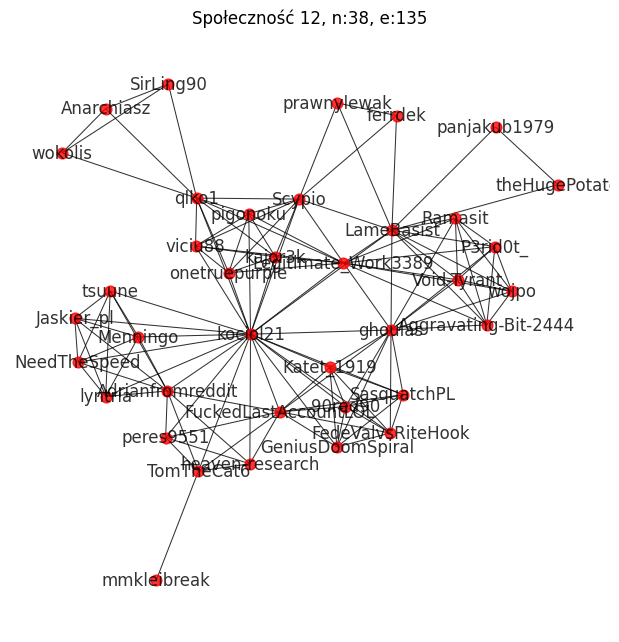

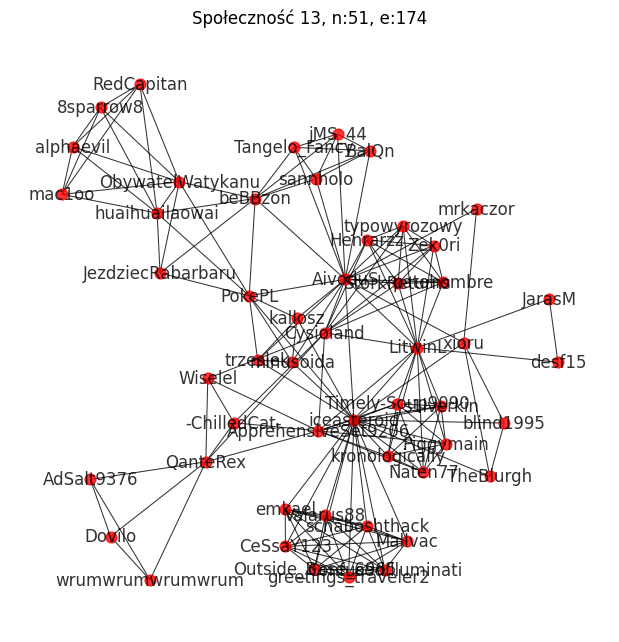

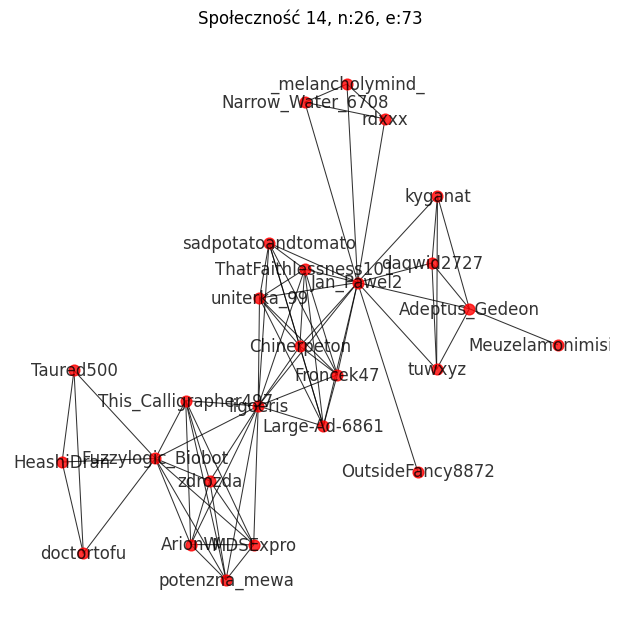

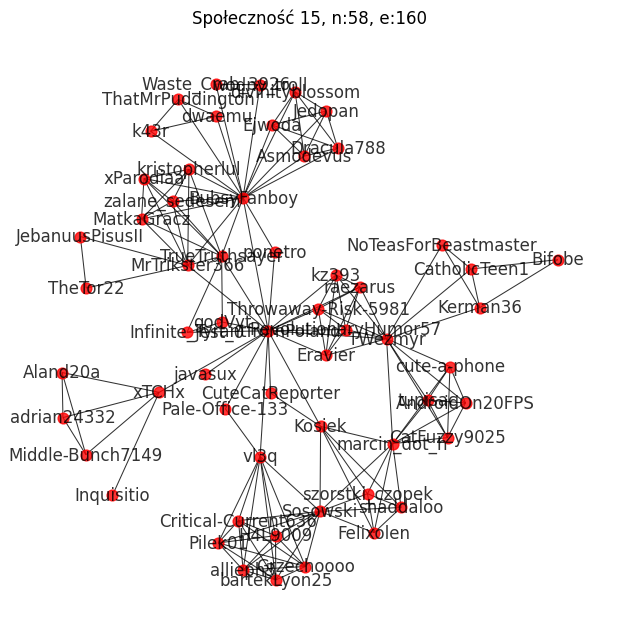

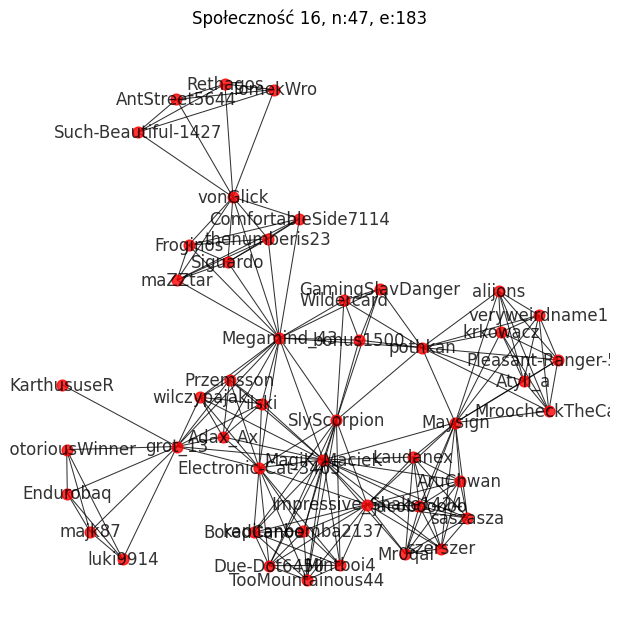

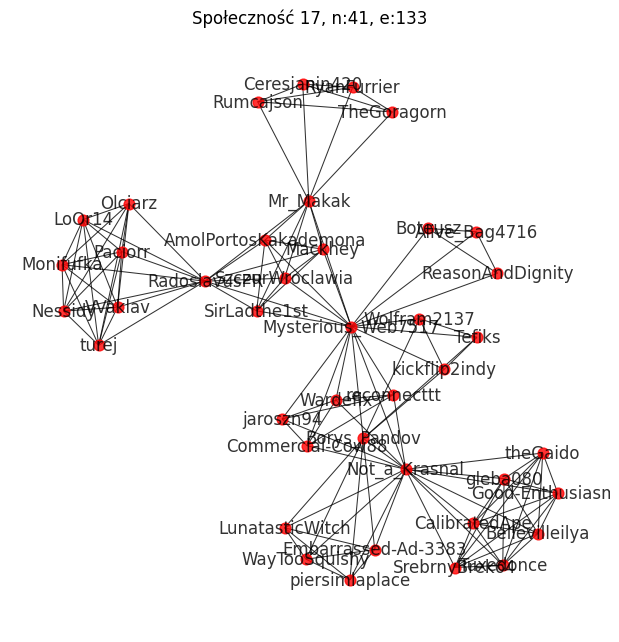

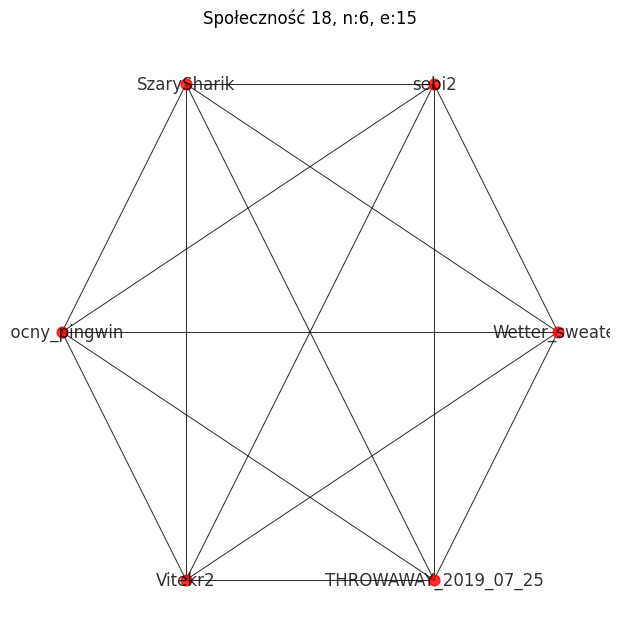

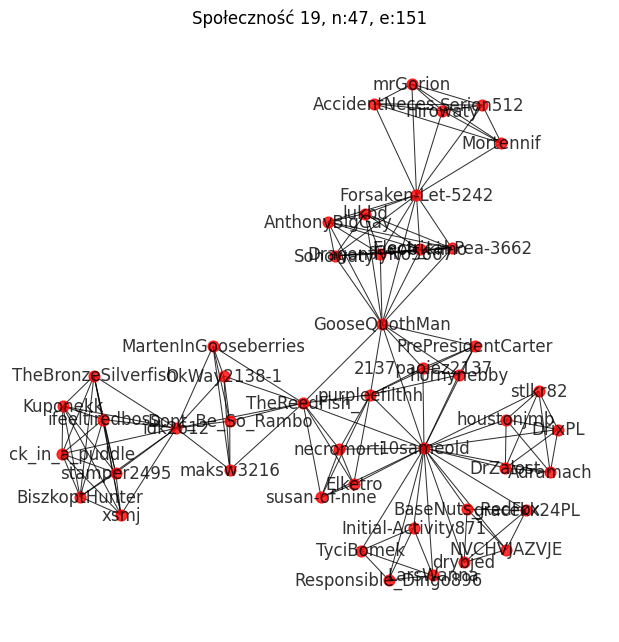

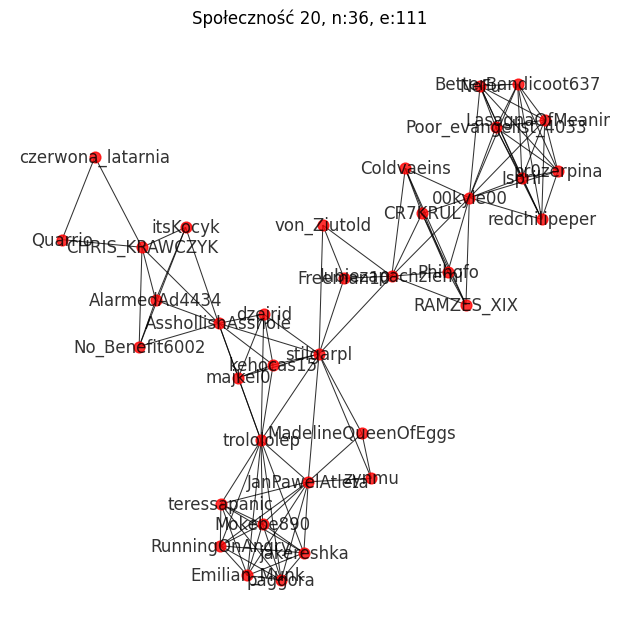

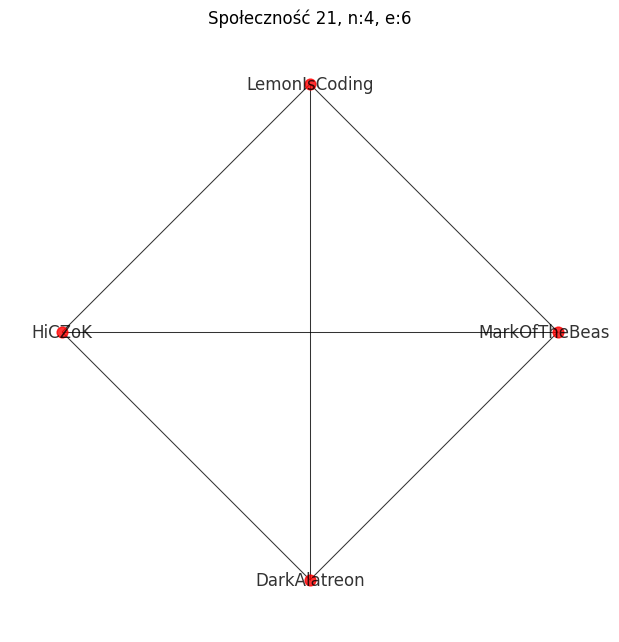

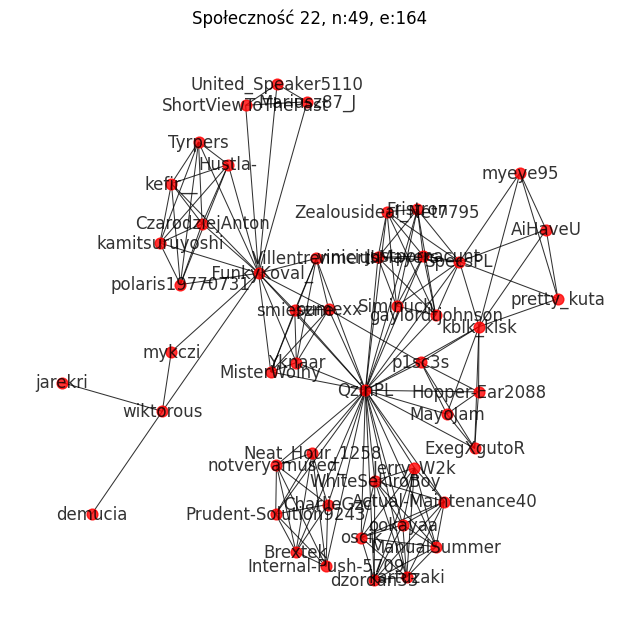

In [ ]:
# wizualizacje społeczności
for i, community in enumerate(communities):
    subgraph = G.subgraph(community)
    plt.figure(figsize=(6, 6))
    nx.draw_kamada_kawai(subgraph, with_labels=True, node_size=60,
                         alpha=0.8, width=0.75, node_color="red")
    plt.title(f"Społeczność {i + 1}, n:{num_nodes[i]}, e:{num_edges[i]}")
    plt.show()

#3. Grupowanie użytkowników wg. tematyki wypowiedzi

Używając wyników modelowania tematycznego z poprzednich zajęć, pogrupuj użytkowników - przyjmij, że osoby udzielające się w obrębie jednego tematu należą do jednej grupy. Grupy mogą się nakładać.

In [ ]:
user = "Igrex"  # Węzeł (użytkownik) do sprawdzenia

if user in G:
    print(f"Węzeł {user} jest w grafie G.")
else:
    print(f"Węzeł {user} nie jest w grafie G.")


Węzeł Igrex nie jest w grafie G.


In [24]:
# słownik dla grup społecznościowych
social_groups = {}

for i, community in enumerate(communities):
    for user in community:
        if i in social_groups:
            social_groups[i].add(user)
        else:
            social_groups[i] = {user}


# słownik dla grup tematycznych
topic_groups = {}

for index, row in wybory_df.iterrows():
    author = row['author']
    topic = row['LDA_topic']

    if author in G:
      if topic in topic_groups:
          if author not in topic_groups[topic]:
              topic_groups[topic].add(author)
      else:
          topic_groups[topic] = {author}


# słownik dla grup sentymentalnych
sentiment_groups = {}

for index, row in wybory_df.iterrows():
    author = row['author']
    topic = row['sentiment']

    if author in G:
      if topic in sentiment_groups:
          if author not in sentiment_groups[topic]:
              sentiment_groups[topic].add(author)
      else:
          sentiment_groups[topic] = {author}


In [26]:
print(f'liczności grup tematycznych:\n0: {len(topic_groups[0])}\n'
     f'1: {len(topic_groups[1])}\n2: {len(topic_groups[2])}\n')

print(f'liczności grup sentymentalnych:\nneg: {len(sentiment_groups["negatywny"])}\n'
     f'pos: {len(sentiment_groups["pozytywny"])}\nneut: {len(sentiment_groups["neutralny"])}')

liczności grup tematycznych:
0: 483
1: 446
2: 314

liczności grup sentymentalnych:
neg: 630
pos: 249
neut: 246


In [27]:
user_to_find = "BubsyFanboy"

for topic, users in social_groups.items():
    if user_to_find in users:
        print(f"Użytkownik {user_to_find} należy do grupy tematycznej {topic}.")

Użytkownik BubsyFanboy należy do grupy tematycznej 14.


<ipython-input-28-27216f715fbd>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



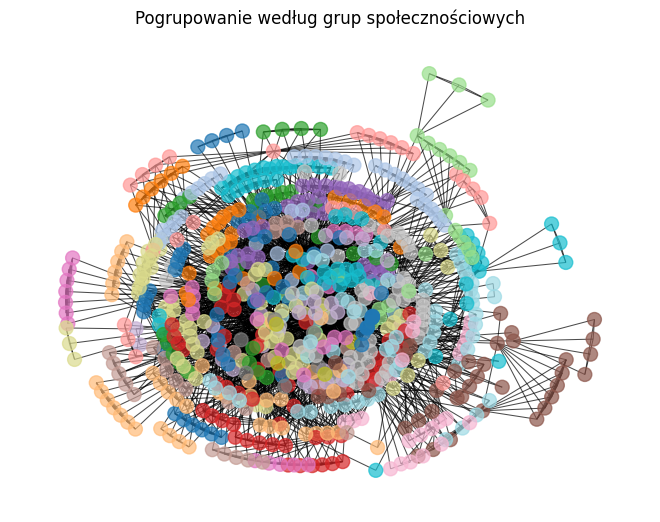

In [28]:
# Przypisanie węzłom grup z grupowania społecznościowego
for i, community in enumerate(communities):
    for user in community:
        G.nodes[user]['com_louvain'] = i

pos = nx.kamada_kawai_layout(G)

node_colors = [G.nodes[node]['com_louvain'] if 'com_louvain' in G.nodes[node] else 0 for node in G.nodes]

nx.draw(G, pos, node_color=node_colors, node_size=100, alpha=0.7, width=0.75,
        cmap=plt.cm.get_cmap('tab20', len(communities)))
plt.title('Pogrupowanie według grup społecznościowych')
plt.show()

<ipython-input-54-143172bfcc98>:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



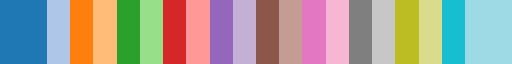

In [ ]:
plt.cm.get_cmap('tab20', len(communities))

#4. Analiza porównawcza wykrytych społeczności

Sprawdź, na ile grupowanie stworzone w pkt 2 nakłada się z grupowaniem stworzonym w pkt 3.

a) (2 pkt) dokonaj porównania zbiorów użytkowników każdy-z-każdym. Możesz użyć dowolnej miary porównania zbiorów, np. miary Jaccarda

b) (1 pkt) przeanalizuj, jak wygląda struktura tematów poruszanych w obrębie grup społecznych - czy istnieje jakiś dominujący temat, czy jest to raczej losowy podział?

c) (1 pkt) oceń, jak wygląda struktura sieci społecznych poruszających dane tematy - czy któryś z tematów został zawłaszczony przez którąś z grup społecznych, czy jest to raczej rozkład równomierny?

Spróbuj zagłębić się w analizy i porównania, badając użytkowników i ich wpisy, by zweryfikować poprawność grupowań.

In [ ]:
def jaccard(groups_1, groups_2):
  jaccard_scores = {}
  for group_1_name, group_1 in groups_1.items():
    for group_2_name, group_2 in groups_2.items():
        intersection = group_1.intersection(group_2)
        union = group_1.union(group_2)
        jaccard = len(intersection) / len(union)
        jaccard_scores[(group_1_name, group_2_name)] = jaccard
  return jaccard_scores

In [ ]:
jac_1_scores = jaccard(social_groups, topic_groups)

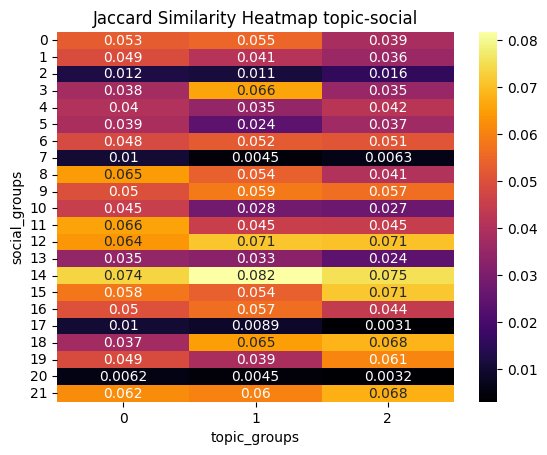

In [ ]:
group_names_1 = list(social_groups.keys())
group_names_2 = list(topic_groups.keys())
score_matrix = np.array([[jac_1_scores[(g1, g2)] for g2 in group_names_2] for g1 in group_names_1])

# Create a heatmap
sns.heatmap(score_matrix, xticklabels=group_names_2, yticklabels=group_names_1, annot=True, cmap="inferno")
plt.xlabel("topic_groups")
plt.ylabel("social_groups")
plt.title("Jaccard Similarity Heatmap topic-social")
plt.show()

In [ ]:
jac_2_scores = jaccard(social_groups, sentiment_groups)

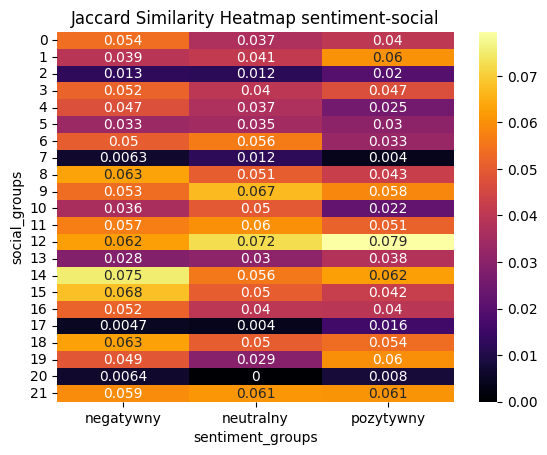

In [ ]:
group_names_1 = list(social_groups.keys())
group_names_2 = list(sentiment_groups.keys())
score_matrix = np.array([[jac_2_scores[(g1, g2)] for g2 in group_names_2] for g1 in group_names_1])

# Create a heatmap
sns.heatmap(score_matrix, xticklabels=group_names_2, yticklabels=group_names_1, annot=True, cmap="inferno")
plt.xlabel("sentiment_groups")
plt.ylabel("social_groups")
plt.title("Jaccard Similarity Heatmap sentiment-social")
plt.show()

In [ ]:
jac_3_scores = jaccard(topic_groups, sentiment_groups)

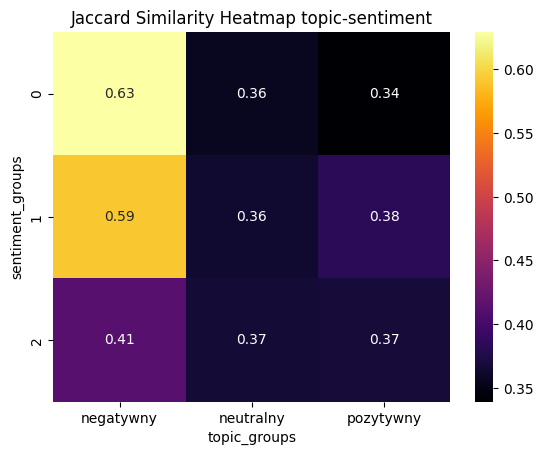

In [ ]:
group_names_1 = list(topic_groups.keys())
group_names_2 = list(sentiment_groups.keys())
score_matrix = np.array([[jac_3_scores[(g1, g2)] for g2 in group_names_2] for g1 in group_names_1])

# Create a heatmap
sns.heatmap(score_matrix, xticklabels=group_names_2, yticklabels=group_names_1, annot=True, cmap="inferno")
plt.xlabel("topic_groups")
plt.ylabel("sentiment_groups")
plt.title("Jaccard Similarity Heatmap topic-sentiment")
plt.show()

In [ ]:
topic_counts_in_social_groups = {}

for social_group, social_users in social_groups.items():
    topic_counts_in_social_groups[social_group] = {}
    for topic in topic_groups.keys():
        topic_counts_in_social_groups[social_group][topic] = 0
    for user in social_users:
        for topic, topic_group in topic_groups.items():
            if user in topic_group:
                topic_counts_in_social_groups[social_group][topic] += 1

df = pd.DataFrame(topic_counts_in_social_groups).T
df.index.name = 'Grupa'
df.reset_index(inplace=True)

In [ ]:
fig = px.bar(df, x='Grupa', y=[0, 1, 2], width=800, height=500,
             title='Liczba tematów w grupach społecznych')
fig.update_yaxes(title='Liczba danych tematów')
fig.update_layout(legend_title_text='Temat')

fig.show()

In [ ]:
sentiment_counts_in_social_groups = {}

for social_group, social_users in social_groups.items():
    sentiment_counts_in_social_groups[social_group] = {}
    for sent in sentiment_groups.keys():
        sentiment_counts_in_social_groups[social_group][sent] = 0
    for user in social_users:
        for sent, sent_group in sentiment_groups.items():
            if user in sent_group:
                sentiment_counts_in_social_groups[social_group][sent] += 1

df = pd.DataFrame(sentiment_counts_in_social_groups).T
df.index.name = 'Grupa'
df.reset_index(inplace=True)

In [ ]:
fig = px.bar(df, x='Grupa', y=['negatywny', 'neutralny', 'pozytywny'], width=800, height=500,
             title='Liczba sentymentów w grupach społecznych')
fig.update_yaxes(title='Liczba danych sentymentów')
fig.update_layout(legend_title_text='Sentyment')

fig.show()

#5. (6 pkt) Badanie podobieństwa społeczności

Używając dostępnych danych o społecznościach (np. rozkład tematów, charaterystyki sieciowe) zaproponuj miarę porównania dwóch społeczności. Wskaż najbardziej i najmniej podobne grupy. Uzasadnij swoją propozycję miary.

Jako miarę podobieństw dwóch społeczności stworzyłem porównywanie rozkładów tematów postów tworzonych w obrębie grupy. Chciałem w ten sposób sprawdzić jak bardzo podobne tematycznie są grupy społeczności stworzone bez wiedzy na temat rozkładów tematów.

In [100]:
def calculate_topic_distribution(topic_group):
    topic_distribution = np.bincount(topic_group, minlength=3) / len(topic_group)
    return topic_distribution

In [134]:
from scipy.stats import entropy

def topic_distribution_similarity(topic_groups, communities):
    similarity_scores = {}

    for i, community_A in enumerate(communities):
      for j, community_B in enumerate(communities):
        topics_A = []
        topics_B = []

        for vertex in community_A:
          for key, value in topic_groups.items():
            if vertex in value:
              topics_A.append(key)

        for vertex in community_B:
          for key, value in topic_groups.items():
            if vertex in value:
              topics_B.append(key)

        if topics_A and topics_B:
          topics_A_dist = calculate_topic_distribution(np.array(topics_A))
          topics_B_dist = calculate_topic_distribution(np.array(topics_B))

          similarity = entropy(topics_A_dist, topics_B_dist)
          similarity_scores[(i, j)] = round(similarity,2)

    return similarity_scores

In [158]:
entropy([0.33,0.30,0.33], [0.33, 0.33, 0.33])

0.0009872274779021348

In [137]:
kls = topic_distribution_similarity(topic_groups, communities)

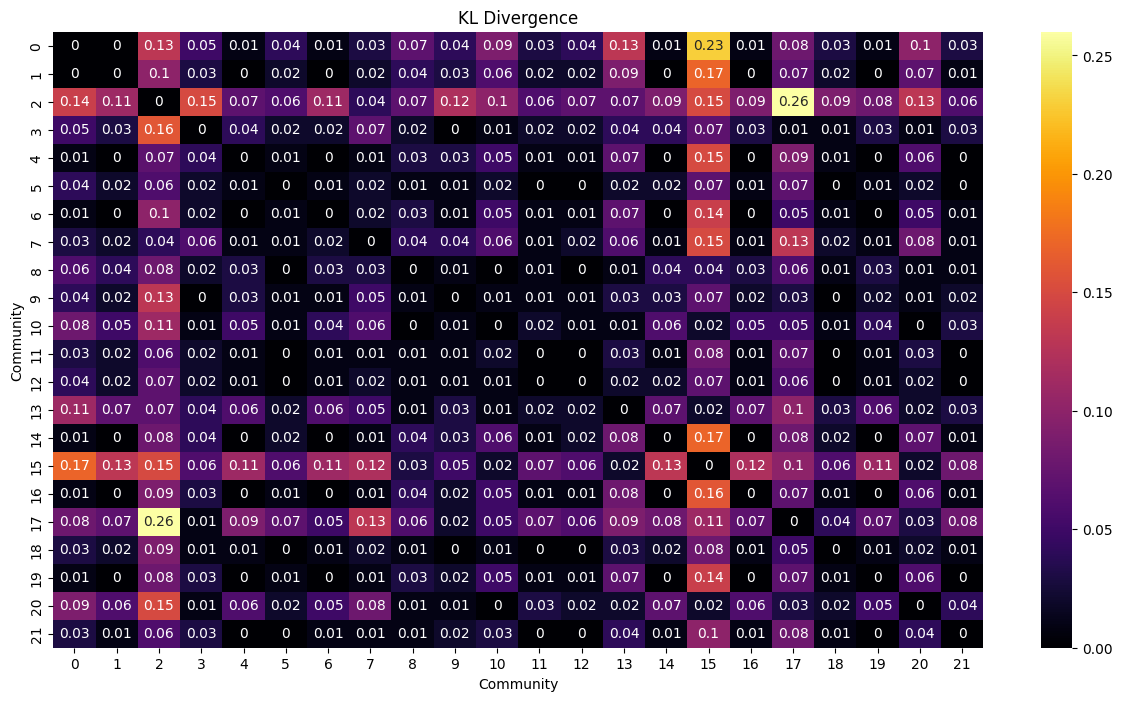

In [159]:
max_group = max(max(key) for key in kls.keys()) + 1
similarity_matrix = np.zeros((max_group, max_group))

for key, value in kls.items():
    i, j = key
    similarity_matrix[i, j] = value

plt.figure(figsize=(15, 8))
sns.heatmap(similarity_matrix, annot=True, cmap="inferno",
            vmin=0, vmax=0.26)

plt.xlabel("Community")
plt.ylabel("Community")
plt.title("KL Divergence")
plt.show()